In [20]:
# from google.colab import drive
# drive.mount('/content/drive')

# !unzip -qq /content/drive/MyDrive/SHIFT/cifar.zip

In [21]:
# hyperparams
epochs = 10
learning_rate = 3e-4
batch_size = 32

## Common part for all models

In [22]:
from torch.utils.data import Dataset
from PIL import Image

import matplotlib.pyplot as plt
import numpy as np

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import torchvision
import torchvision.transforms as transforms

from typing import Tuple
from typing import Callable # for type of criterion

from tqdm import tqdm

from torch.optim import lr_scheduler

import wandb

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [23]:
def seed_everything(seed: int):
    import random, os
    
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True 
    # будет работать - если граф вычислений не будет меняться во время обучения
    torch.backends.cudnn.benchmark = True # оптимизации
seed_everything(42)

In [24]:
transform_train = transforms.Compose([
            transforms.RandomCrop(32, padding=4),
            transforms.RandomHorizontalFlip(),
            transforms.ToTensor(),
            transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
        ])
transform_val = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

train_dataset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform_train)


test_dataset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform_val)

Files already downloaded and verified
Files already downloaded and verified


In [25]:
train_loader = torch.utils.data.DataLoader(
    train_dataset, 
    batch_size=batch_size,
    shuffle=True,
    drop_last=True,
    num_workers=2,
    pin_memory=True,
)

test_loader = torch.utils.data.DataLoader(
    test_dataset, 
    batch_size=batch_size,
    shuffle=False,
    num_workers=2,
    pin_memory=True,
)

In [27]:
def train_one_epoch(
    model: nn.Module,
    dataloader: torch.utils.data.DataLoader,
    optimizer: torch.optim.Optimizer,
    criterion: Callable,
    scheduler
) -> Tuple[float, float]:
    scheduler.step()
    model.train() 

    train_running_loss = 0.0
    train_running_correct = 0
    total_epoch_steps = int(len(dataloader.dataset)/dataloader.batch_size)

    for _, batch in tqdm(enumerate(dataloader), total=total_epoch_steps):
        [images, target] = batch
        images, target = images.to(device), target.to(device)
        outputs = model(images)
        
        loss = criterion(outputs, target)
        train_running_loss += loss.item()

        _, preds = torch.max(outputs.data, 1)
        train_running_correct += (preds == target).sum().item()

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
    train_loss = train_running_loss/len(dataloader.dataset)
    train_accuracy = 100. * train_running_correct/len(dataloader.dataset)    
    return train_loss, train_accuracy


def validate(
    model: nn.Module,
    dataloader: torch.utils.data.DataLoader
) -> Tuple[float, float]:

    model.eval()

    val_running_loss = 0.0
    val_running_correct = 0

    with torch.no_grad():
        inference_steps = int(len(dataloader.dataset)/dataloader.batch_size)

        for _, batch in tqdm(enumerate(dataloader), total=inference_steps):
            
            [images, target] = batch
            images = images.to(device)
            target = target.to(device)

            outputs = model(images)
            loss = criterion(outputs, target)
            
            val_running_loss += loss.item()
            _, preds = torch.max(outputs.data, 1)
            val_running_correct += (preds == target).sum().item()
        
        val_loss = val_running_loss/len(dataloader.dataset)
        val_accuracy = 100. * val_running_correct/len(dataloader.dataset)        
        return val_loss, val_accuracy

In [28]:
def model_learning(
    epochs: int,    
    model: nn.Module,
    optimizer: torch.optim.Optimizer,
    criterion: Callable,
    scheduler
) -> Tuple[float, float]:
    train_loss, train_accuracy, test_loss, test_accuracy = [], [], [], []

    # start a new wandb run to track this script
    wandb.init(
        # set the wandb project where this run will be logged
        project="my-awesome-project",
        
        # track hyperparameters and run metadata
        config={
        "learning_rate": 3e-4,
        "architecture": "CNN",
        "dataset": "CIFAR-100",
        "epochs": epochs,
        }
    )


    for epoch in range(epochs):
        print(f"\nEpoch {epoch+1} of {epochs}")
        train_epoch_loss, train_epoch_accuracy = train_one_epoch(model, train_loader, optimizer, criterion, scheduler)

        train_loss.append(train_epoch_loss)
        train_accuracy.append(train_epoch_accuracy)

        print(f"\nTrain Loss: {train_epoch_loss:.4f}, Train Acc: {train_epoch_accuracy:.2f}")

        val_loss, val_accuracy = validate(model, test_loader)
        test_loss.append(val_loss)
        test_accuracy.append(val_accuracy)
        print(f"\nTest Loss: {val_loss:.4f}, Test Acc: {val_accuracy:.2f}")


        wandb.log({"acc": val_accuracy, "loss": val_loss})
            
    wandb.finish()
    return train_loss, train_accuracy, test_loss, test_accuracy

In [29]:
def plot_training(train_losses, valid_losses, train_accuracies, valid_accuracies):
    plt.figure(figsize=(12, 9))
    plt.subplot(2, 1, 1)
    plt.xlabel("epoch")
    plt.plot(train_losses, label="train_loss")
    plt.plot(valid_losses, label="valid_loss")
    plt.legend()
    
    plt.subplot(2, 1, 2)
    plt.xlabel("epoch")
    plt.plot(train_accuracies, label="train accuracy")
    plt.plot(valid_accuracies, label="valid accuracy")
    plt.legend()

In [ ]:
def calc_accuracy(model, loader):
    test_acc = 0.0
    for samples, labels in loader:
        with torch.no_grad():
            samples, labels = samples.to(device), labels.to(device)
            output = model(samples)
            # calculate accuracy
            pred = torch.argmax(output, dim=1)
            correct = pred.eq(labels)
            test_acc += torch.mean(correct.float())
    print('Accuracy of the network on {} test images: {}%'.format(len(loader), round(test_acc.item()*100.0/len(loader), 2)))

## CNN Basic model architecture 

![image.png](https://wikidocs.net/images/page/164499/Cifar10_CNN.jpg) <br>
image courtesy : https://wikidocs.net/165444

In [ ]:
class BasicNet(nn.Module):
    def __init__(self):
        super(BasicNet, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=32, kernel_size=5, padding=2)
        self.pool1 = nn.MaxPool2d(kernel_size=4, stride=2, padding=1, dilation=1)
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=16, kernel_size=5, padding=2)
        self.pool2 = nn.MaxPool2d(kernel_size=2)

        self.conv3 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=5, padding=2)
        self.pool3 = nn.MaxPool2d(kernel_size=4, stride=2, padding=1, dilation=1)

        self.fc1 = nn.Linear(in_features=32, out_features=1000)
        self.fc2 = nn.Linear(in_features=1000, out_features=10)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        # x = self.dropout(x)
        x = self.pool1(x)
        x = F.relu(self.conv2(x))
        x = self.pool2(x)
        x = F.relu(self.conv3(x))
        x = self.pool3(x)
        bs, _, _, _ = x.shape
        x = F.adaptive_avg_pool2d(x, 1).reshape(bs, -1)
        x = F.relu(self.fc1(x))
        # x = self.dropout(x)
        out = self.fc2(x)
        return x
model = BasicNet().to(device)
optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate)
criterion = nn.CrossEntropyLoss()

In [ ]:
optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate)
exp_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1)
criterion = nn.CrossEntropyLoss()

train_loss, train_accuracy, test_loss, test_accuracy = model_learning(30,model, optimizer, criterion, exp_lr_scheduler)

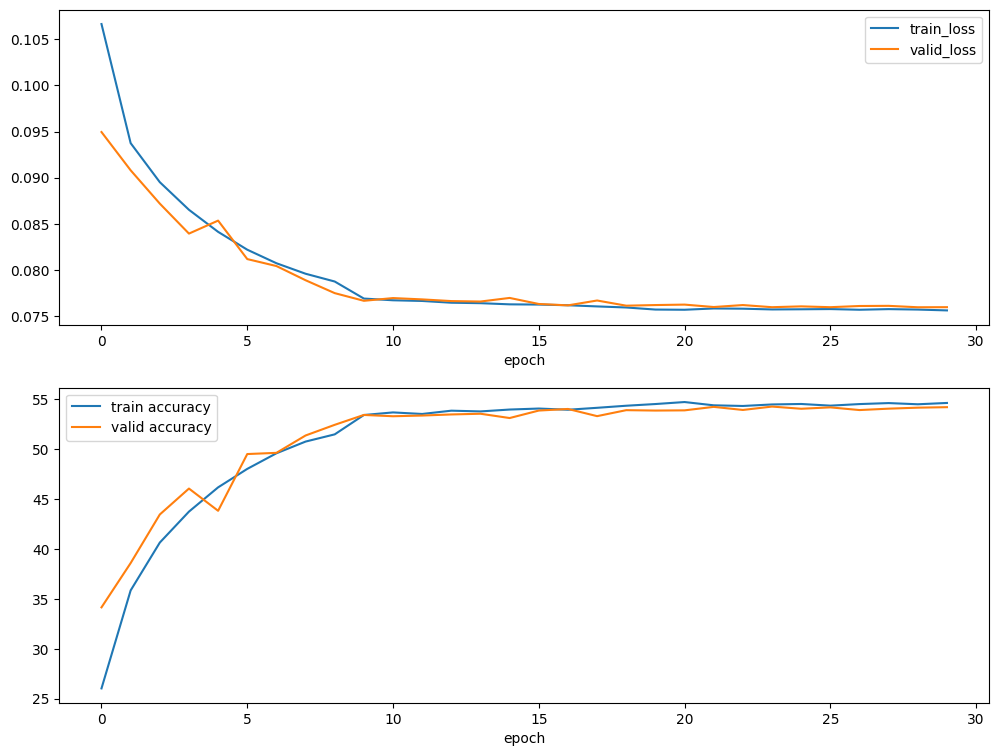

In [33]:
plot_training(train_loss, test_loss, train_accuracy, test_accuracy)

In [34]:
calc_accuracy(model, test_loader)

Accuracy of the network on 313 test images: 54.2%


## Simple another

In [ ]:
class SimpleNet_v2(nn.Module):
    def __init__(self):
        super(SimpleNet_v2, self).__init__()
        # 1 input image channel, 6 output channels, 3x3 square conv kernel
        self.conv1 = nn.Conv2d(3, 6, 3)
        self.conv2 = nn.Conv2d(6, 16, 3)
        self.fc1 = nn.Linear(16 * 6 * 6, 120)  # 5x5 image dimension
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = F.max_pool2d(F.relu(self.conv1(x)), (2, 2))
        x = F.max_pool2d(F.relu(self.conv2(x)), 2)
        x = x.view(x.shape[0], -1)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x
model_v2 = SimpleNet_v2().to(device)
optimizer = torch.optim.AdamW(model_v2.parameters(), lr=learning_rate)
criterion = nn.CrossEntropyLoss()
exp_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1)
train_loss, train_accuracy, test_loss, test_accuracy = model_learning(10,model_v2, optimizer, criterion, exp_lr_scheduler)

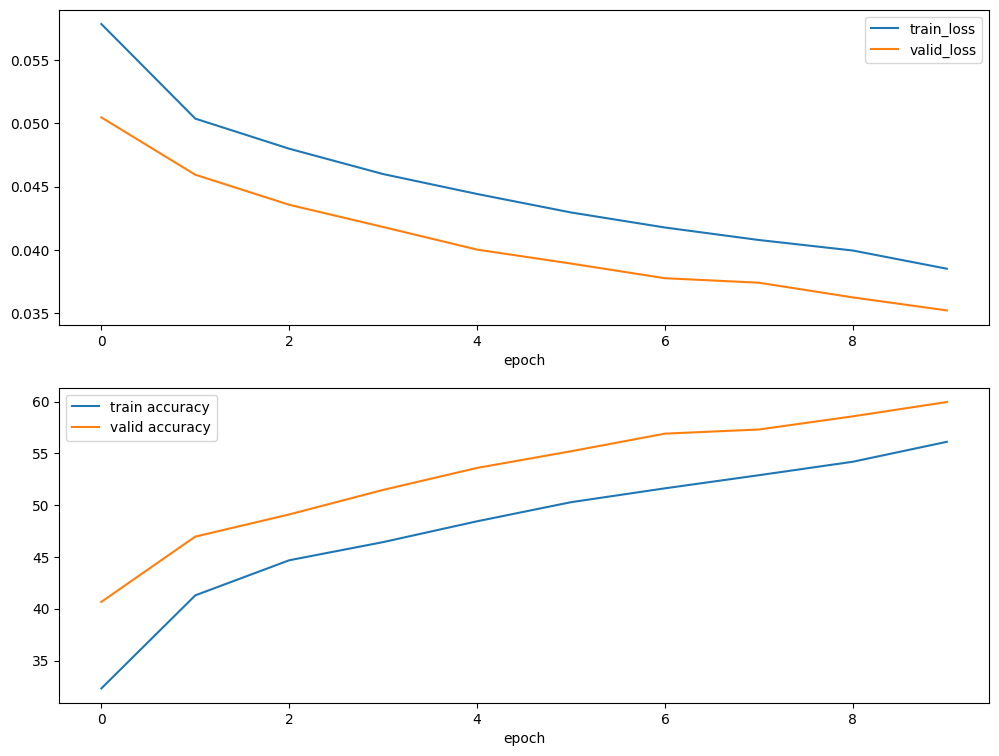

In [36]:
plot_training(train_loss, test_loss, train_accuracy, test_accuracy)

In [37]:
calc_accuracy(model_v2, test_loader)

Accuracy of the network on 313 test images: 59.93%


## Add batch normalization

In [ ]:
class SimpleNet_v3(nn.Module):
    def __init__(self):
        super(SimpleNet_v3, self).__init__()
        # 1 input image channel, 6 output channels, 3x3 square conv kernel
        self.conv1 = nn.Conv2d(3, 6, 3)
        self.bn1 = nn.BatchNorm2d(6)
        self.conv2 = nn.Conv2d(6, 16, 3)
        self.bn2 = nn.BatchNorm2d(16)
        self.fc1 = nn.Linear(16 * 6 * 6, 120)  # 5x5 image dimension
        self.bn3 = nn.BatchNorm1d(120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = self.bn1(F.max_pool2d(F.relu(self.conv1(x)), (2, 2)))
        x = self.bn2(F.max_pool2d(F.relu(self.conv2(x)), 2))
        x = x.view(x.shape[0], -1)
        x = self.bn3(F.relu(self.fc1(x)))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x
model_v3 = SimpleNet_v3().to(device)
optimizer = torch.optim.AdamW(model_v3.parameters(), lr=learning_rate)
criterion = nn.CrossEntropyLoss()
exp_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1)
train_loss, train_accuracy, test_loss, test_accuracy = model_learning(10,model_v3, optimizer, criterion, exp_lr_scheduler)

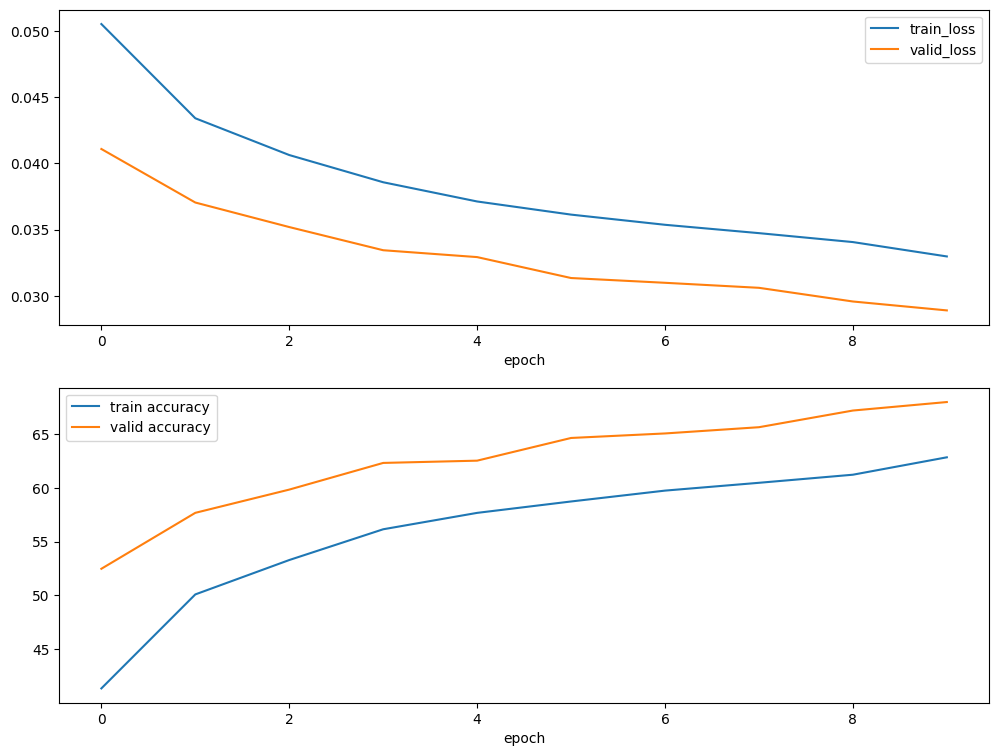

In [39]:
plot_training(train_loss, test_loss, train_accuracy, test_accuracy)

In [40]:
calc_accuracy(model_v3, test_loader)

Accuracy of the network on 313 test images: 67.97%


## Add dropout

In [ ]:
class ModelDropout(nn.Module):
    def __init__(self):
        super(ModelDropout, self).__init__()
        # 1 input image channel, 6 output channels, 3x3 square conv kernel
        self.conv1 = nn.Conv2d(3, 6, 3)
        self.conv2 = nn.Conv2d(6, 16, 3)
        self.fc1 = nn.Linear(16 * 6 * 6, 120)  # 5x5 image dimension
        self.dropout = nn.Dropout(p=0.3)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = F.max_pool2d(F.relu(self.conv1(x)), (2, 2))
        x = F.max_pool2d(F.relu(self.conv2(x)), 2)
        x = x.view(x.shape[0], -1)
        x = self.dropout(F.relu(self.fc1(x)))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x
    
model_v4 = ModelDropout().to(device)
optimizer = torch.optim.AdamW(model_v4.parameters(), lr=learning_rate)
criterion = nn.CrossEntropyLoss()
exp_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1)
train_loss, train_accuracy, test_loss, test_accuracy = model_learning(10,model_v4, optimizer, criterion, exp_lr_scheduler)

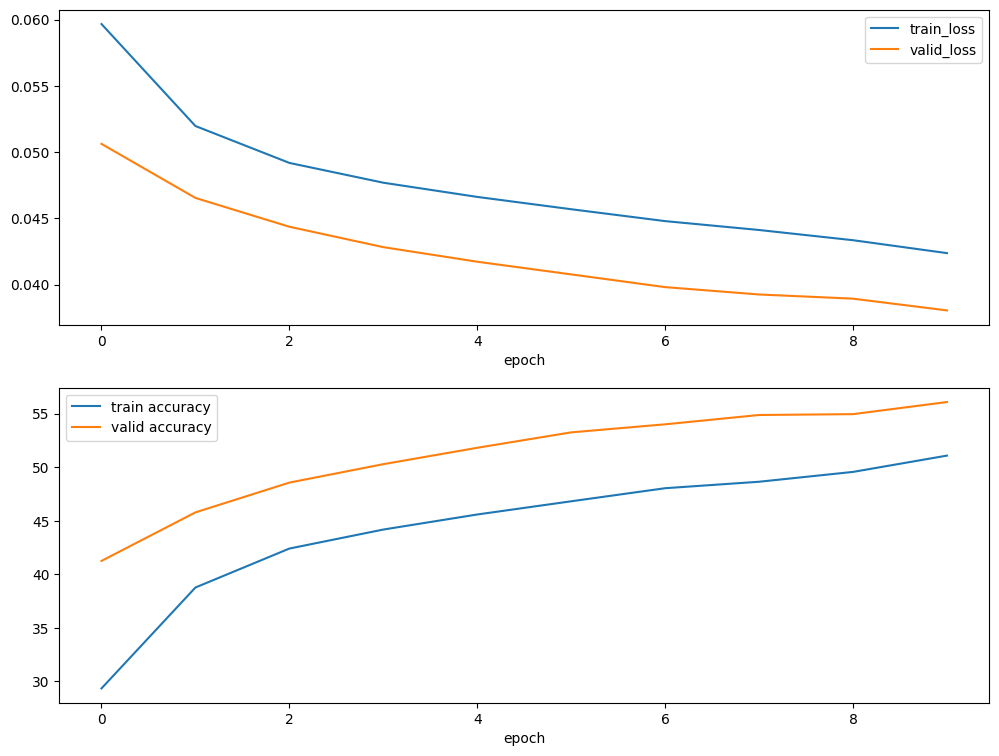

In [42]:
plot_training(train_loss, test_loss, train_accuracy, test_accuracy)

In [43]:
calc_accuracy(model_v4, test_loader)

Accuracy of the network on 313 test images: 56.08%


## Add dropout and normalization

In [ ]:
class SimpleNet_drop_norm(nn.Module):
    def __init__(self):
        super(SimpleNet_drop_norm, self).__init__()
        # 1 input image channel, 6 output channels, 3x3 square conv kernel
        self.conv1 = nn.Conv2d(3, 6, 3)
        self.bn1 = nn.BatchNorm2d(6)
        self.conv2 = nn.Conv2d(6, 16, 3)
        self.bn2 = nn.BatchNorm2d(16)
        self.fc1 = nn.Linear(16 * 6 * 6, 120)  # 5x5 image dimension
        self.dropout1 = nn.Dropout(p=0.3)
        self.bn3 = nn.BatchNorm1d(120)
        self.fc2 = nn.Linear(120, 84)
        self.dropout2 = nn.Dropout(p=0.1)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = self.bn1(F.max_pool2d(F.relu(self.conv1(x)), (2, 2)))
        x = self.bn2(F.max_pool2d(F.relu(self.conv2(x)), 2))
        x = x.view(x.shape[0], -1)
        x = self.bn3(self.dropout1(F.relu(self.fc1(x))))
        x = self.dropout2(F.relu(self.fc2(x)))
        x = self.fc3(x)
        return x
model_v4 =SimpleNet_drop_norm().to(device)
optimizer = torch.optim.AdamW(model_v4.parameters(), lr=learning_rate)
criterion = nn.CrossEntropyLoss()
exp_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1)
train_loss, train_accuracy, test_loss, test_accuracy = model_learning(10,model_v4, optimizer, criterion, exp_lr_scheduler)

Accuracy of the network on 313 test images: 63.51%


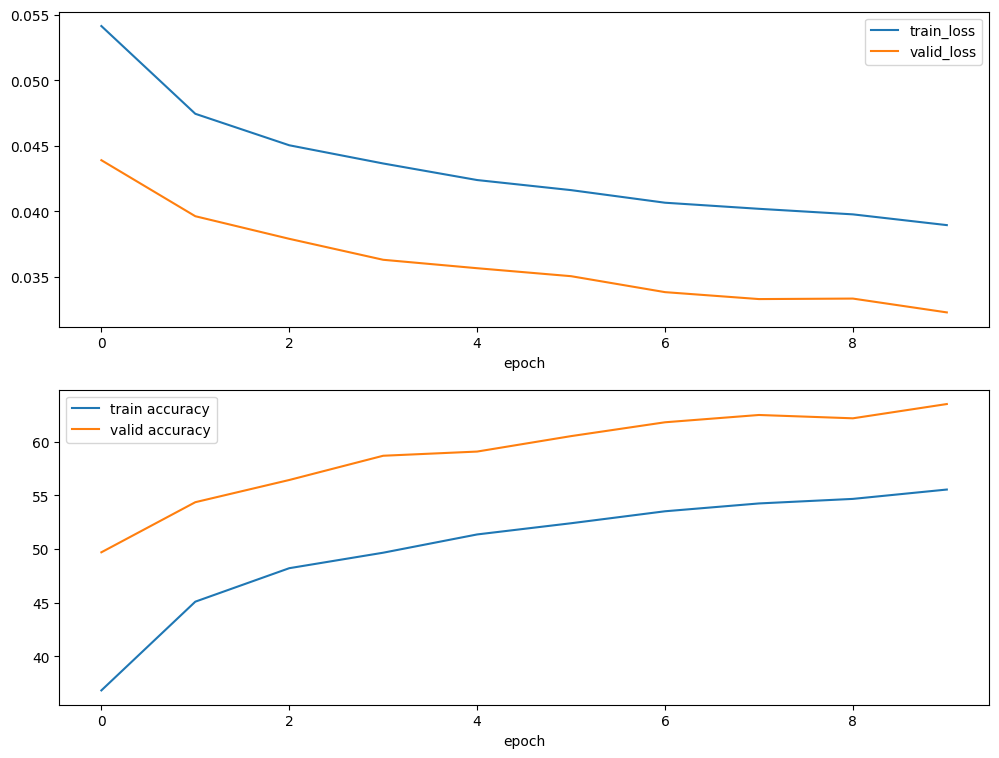

In [45]:
plot_training(train_loss, test_loss, train_accuracy, test_accuracy)
calc_accuracy(model_v4, test_loader)

Change dropout and banch normal

In [ ]:
class SimpleNet_drop_norm_v2(nn.Module):
    def __init__(self):
        super(SimpleNet_drop_norm_v2, self).__init__()
        # 1 input image channel, 6 output channels, 3x3 square conv kernel
        self.conv1 = nn.Conv2d(3, 6, 3)
        self.bn1 = nn.BatchNorm2d(6)
        self.conv2 = nn.Conv2d(6, 16, 3)
        self.bn2 = nn.BatchNorm2d(16)
        self.fc1 = nn.Linear(16 * 6 * 6, 120)  # 5x5 image dimension
        self.dropout1 = nn.Dropout(p=0.3)
        self.bn3 = nn.BatchNorm1d(120)
        self.fc2 = nn.Linear(120, 84)
        self.dropout2 = nn.Dropout(p=0.1)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = self.bn1(F.max_pool2d(F.relu(self.conv1(x)), (2, 2)))
        x = self.bn2(F.max_pool2d(F.relu(self.conv2(x)), 2))
        x = x.view(x.shape[0], -1)
        x = self.dropout1(self.bn3(F.relu(self.fc1(x))))
        x = self.dropout2(F.relu(self.fc2(x)))
        x = self.fc3(x)
        return x
model_v6 =SimpleNet_drop_norm_v2().to(device)
optimizer = torch.optim.AdamW(model_v6.parameters(), lr=learning_rate)
criterion = nn.CrossEntropyLoss()
exp_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1)
train_loss, train_accuracy, test_loss, test_accuracy = model_learning(10,model_v6, optimizer, criterion, exp_lr_scheduler)

Accuracy of the network on 313 test images: 64.42%


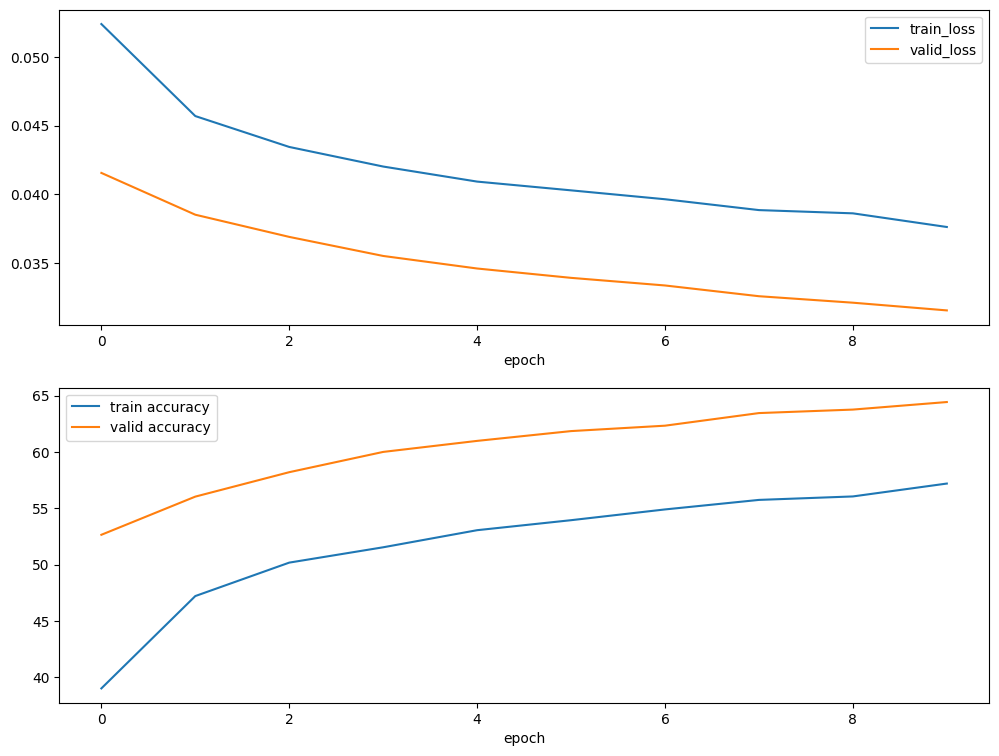

In [47]:
plot_training(train_loss, test_loss, train_accuracy, test_accuracy)
calc_accuracy(model_v6, test_loader)

add dropout between convolution before batch normalization

In [ ]:
class SimpleNet_drop_norm_v1(nn.Module):
    def __init__(self):
        super(SimpleNet_drop_norm_v1, self).__init__()
        # 1 input image channel, 6 output channels, 3x3 square conv kernel
        self.conv1 = nn.Conv2d(3, 6, 3)
        self.dropout1 = nn.Dropout(p=0.3)
        self.bn1 = nn.BatchNorm2d(6)
        self.conv2 = nn.Conv2d(6, 16, 3)
        self.dropout2 = nn.Dropout(p=0.4)
        self.bn2 = nn.BatchNorm2d(16)
        self.fc1 = nn.Linear(16 * 6 * 6, 120)  # 5x5 image dimension
        self.dropout3 = nn.Dropout(p=0.3)
        self.bn3 = nn.BatchNorm1d(120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = self.bn1(self.dropout1(F.max_pool2d(F.relu(self.conv1(x)), (2, 2))))
        x = self.bn2(self.dropout1(F.max_pool2d(F.relu(self.conv2(x)), 2)))
        x = x.view(x.shape[0], -1)
        x = self.bn3(self.dropout1(F.relu(self.fc1(x))))
        x = self.dropout2(F.relu(self.fc2(x)))
        x = self.fc3(x)
        return x
model_v5 =SimpleNet_drop_norm_v1().to(device)
optimizer = torch.optim.AdamW(model_v5.parameters(), lr=learning_rate)
criterion = nn.CrossEntropyLoss()
exp_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1)
train_loss, train_accuracy, test_loss, test_accuracy = model_learning(10,model_v5, optimizer, criterion, exp_lr_scheduler)

Accuracy of the network on 313 test images: 64.42%


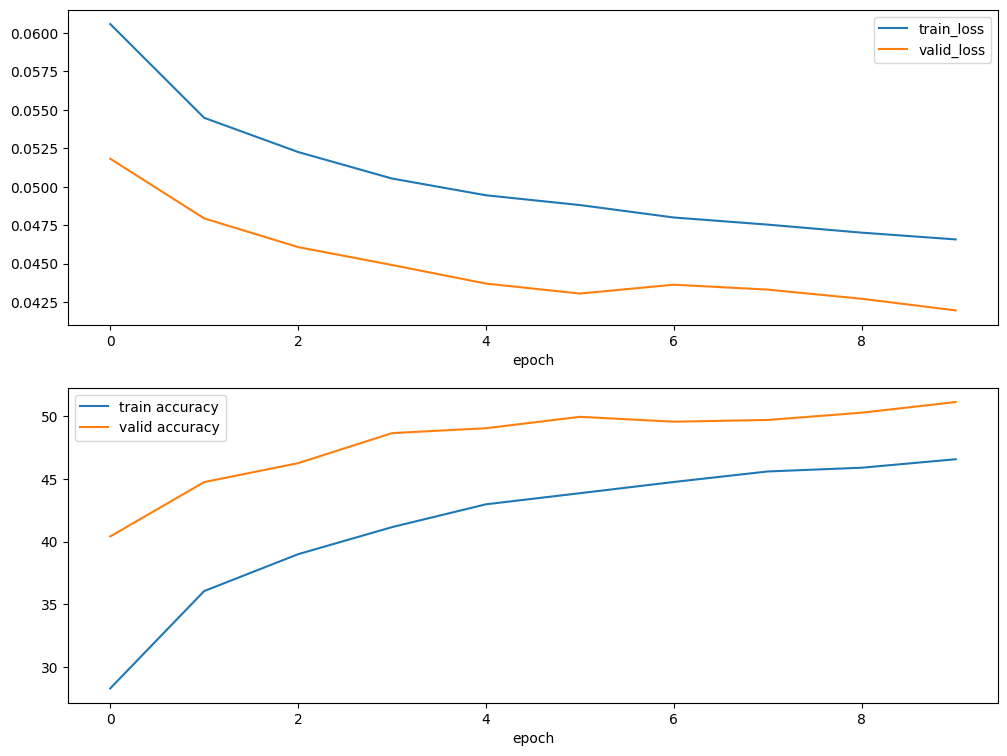

In [49]:
plot_training(train_loss, test_loss, train_accuracy, test_accuracy)
calc_accuracy(model_v6, test_loader)

Change drop and norm 

In [ ]:
class SimpleNet_drop_norm_v3(nn.Module):
    def __init__(self):
        super(SimpleNet_drop_norm_v3, self).__init__()
        # 1 input image channel, 6 output channels, 3x3 square conv kernel
        self.conv1 = nn.Conv2d(3, 6, 3)
        self.dropout1 = nn.Dropout(p=0.3)
        self.bn1 = nn.BatchNorm2d(6)
        self.conv2 = nn.Conv2d(6, 16, 3)
        self.dropout2 = nn.Dropout(p=0.4)
        self.bn2 = nn.BatchNorm2d(16)
        self.fc1 = nn.Linear(16 * 6 * 6, 120)  # 5x5 image dimension
        self.dropout3 = nn.Dropout(p=0.3)
        self.bn3 = nn.BatchNorm1d(120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = self.dropout1(self.bn1(F.max_pool2d(F.relu(self.conv1(x)), (2, 2))))
        x = self.dropout1(self.bn2(F.max_pool2d(F.relu(self.conv2(x)), 2)))
        x = x.view(x.shape[0], -1)
        x = self.dropout1(self.bn3(F.relu(self.fc1(x))))
        x = self.dropout2(F.relu(self.fc2(x)))
        x = self.fc3(x)
        return x
model_v7 =SimpleNet_drop_norm_v3().to(device)
optimizer = torch.optim.AdamW(model_v7.parameters(), lr=learning_rate)
criterion = nn.CrossEntropyLoss()
exp_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1)
train_loss, train_accuracy, test_loss, test_accuracy = model_learning(10,model_v7, optimizer, criterion, exp_lr_scheduler)

Accuracy of the network on 313 test images: 54.52%


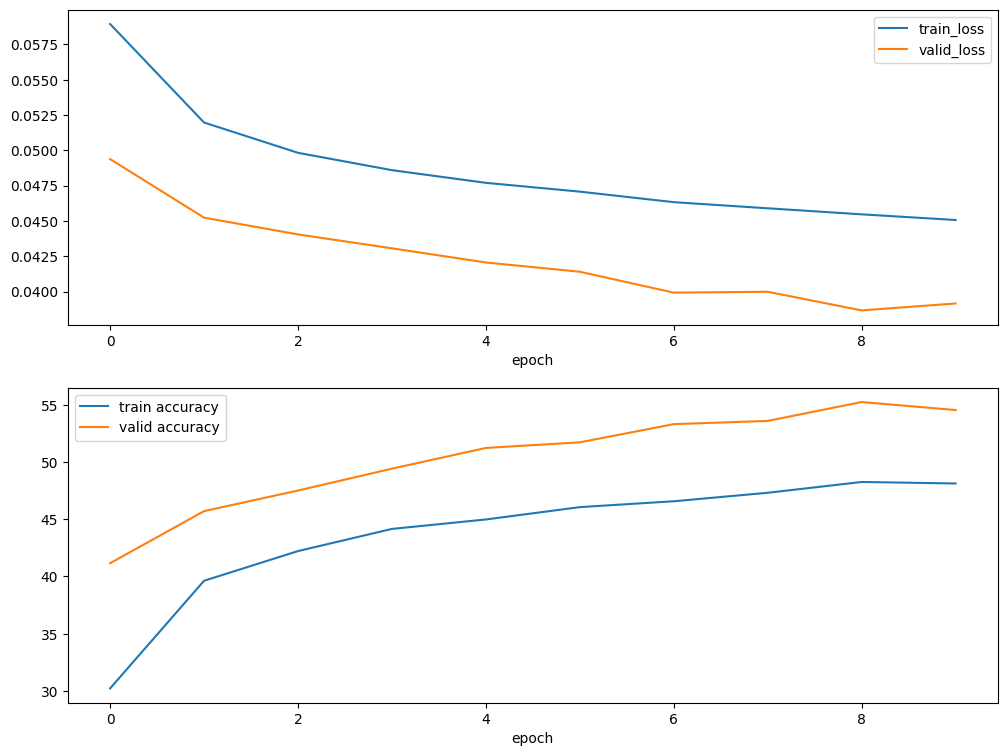

In [51]:
plot_training(train_loss, test_loss, train_accuracy, test_accuracy)
calc_accuracy(model_v7, test_loader)